In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
n_samples = 1440  # 24시간 (분 단위)
minutes = np.arange(n_samples)
hours = (minutes / 60) % 24

# 1. 상태(Base State) 정의 함수
# 0: 수면, 1: 가벼운 활동/휴식, 2: 강한 활동(운동 등), 3: 중간 깨어남
def get_true_state(h):
    if 0 <= h < 7: # 기본 수면 시간
        if 3.5 <= h < 3.8: return 3 # 새벽에 잠시 깨서 뒤척임
        return 0
    elif 7 <= h < 9: return 1   # 아침 준비 및 출근
    elif 9 <= h < 12: return 2  # 오전 업무 (활동적)
    elif 12 <= h < 13.5: return 1 # 점심 식사 및 낮잠 (휴식)
    elif 13.5 <= h < 18: return 2 # 오후 활동
    elif 18 <= h < 22: return 1  # 저녁 휴식
    else: return 0              # 야간 취침 시작

true_states = np.array([get_true_state(h) for h in hours])

# 2. 상태별 생체 신호 생성
hr = []
spo2 = []
movement = []

for s in true_states:
    if s == 0: # 수면
        hr.append(np.random.normal(55, 3))
        spo2.append(np.random.normal(98, 0.4))
        movement.append(np.random.uniform(0, 0.1))
    elif s == 1: # 휴식/낮잠
        hr.append(np.random.normal(70, 5))
        spo2.append(np.random.normal(97, 0.5))
        movement.append(np.random.uniform(0.1, 0.8))
    elif s == 2: # 활동
        hr.append(np.random.normal(95, 12))
        spo2.append(np.random.normal(96, 0.8))
        movement.append(np.random.uniform(1.0, 5.0))
    elif s == 3: # 새벽에 깨어남
        hr.append(np.random.normal(75, 7))
        spo2.append(np.random.normal(97, 0.5))
        movement.append(np.random.uniform(0.5, 2.0))

# 3. 데이터프레임 구성
df = pd.DataFrame({
    'hr': hr,
    'spo2': spo2,
    'movement': movement,
    'hour': hours
})

# 4. 피처 엔지니어링 (주기성 변환)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# 5. 특성 선택 및 정규화
features = ['hr', 'spo2', 'movement', 'hour_sin', 'hour_cos']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

print("데이터 생성 완료! 다양한 패턴(새벽 깨어남, 낮잠 등)이 포함되었습니다.")

데이터 생성 완료! 다양한 패턴(새벽 깨어남, 낮잠 등)이 포함되었습니다.


In [2]:
# 2. GMM (Gaussian Mixture Model) 단계

n_components = 3
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(X_scaled)

# 각 데이터 포인트가 3개 분포에 속할 '확률'을 추출 (Soft Clustering)
gmm_probs = gmm.predict_proba(X_scaled)

In [3]:
# GMM의 확률 시퀀스를 입력으로 받아 시간적 흐름(전이)을 학습합니다.

hmm_model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", n_iter=5000, tol=10.0, init_params="mc")

# HMM 모델이 a -> b 로 간다했을 때 b를 어느 정도 유지시켰습니다.
hmm_model.startprob_ = np.array([1/3, 1/3, 1/3])
hmm_model.transmat_ = np.array([
    [0.99, 0.005, 0.005],
    [0.005, 0.99, 0.005],
    [0.005, 0.005, 0.99]
])

hmm_model.fit(gmm_probs)

# HMM이 결정한 가장 가능성 높은 은닉 상태 시퀀스 추출
final_states = hmm_model.predict(gmm_probs)
df['state'] = final_states

Model is not converging.  Current: 14661.40312713884 is not greater than 18597.273601699573. Delta is -3935.870474560734


In [4]:
# 4. 사후 라벨링 (Post-labeling)
state_means = df.groupby('state')['hr'].mean().sort_values()
label_map = {
    state_means.index[0]: "수면(Sleep)",
    state_means.index[1]: "휴식(Rest)",
    state_means.index[2]: "활동(Active)"
}
df['label'] = df['state'].map(label_map)

C:\Users\rlaau\AppData\Local\Temp\ipykernel_32224\3529565116.py:19: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rlaau\AppData\Local\Temp\ipykernel_32224\3529565116.py:19: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rlaau\AppData\Local\Temp\ipykernel_32224\3529565116.py:19: UserWarning: Glyph 55092 (\N{HANGUL SYLLABLE HYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rlaau\AppData\Local\Temp\ipykernel_32224\3529565116.py:19: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rlaau\AppData\Local\Temp\ipykernel_32224\3529565116.py:19: UserWarning: Glyph 54876 (\N{HANGUL SYLLABLE HWAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rlaau\AppData\Local\Temp\ipykernel_32224\3529565116.py:19: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing 

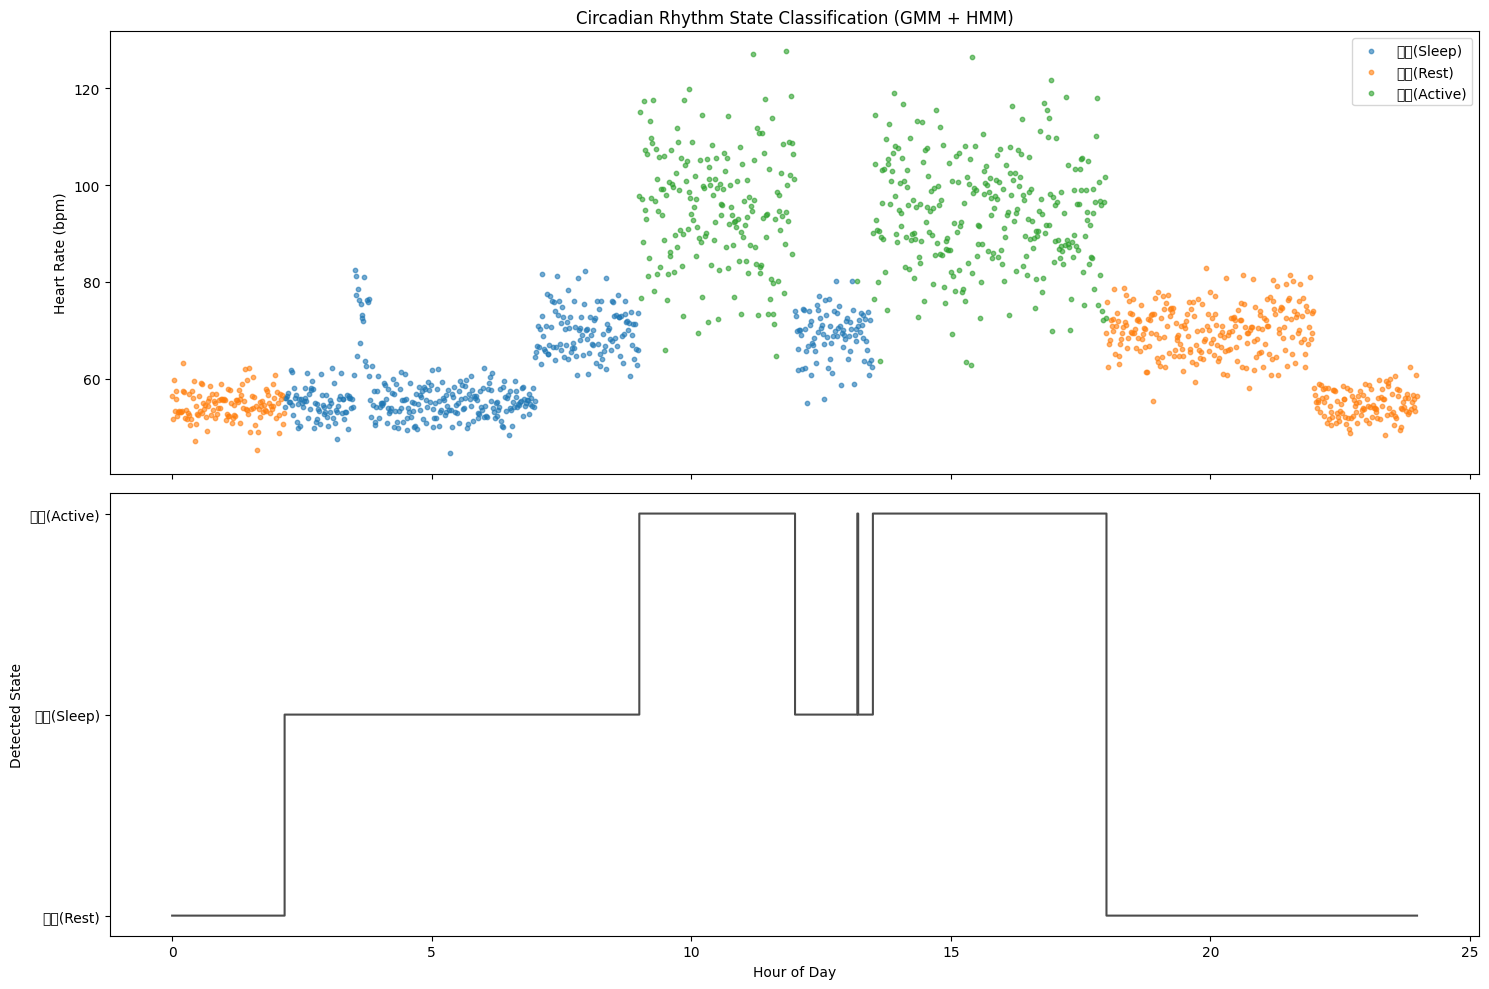

--- 상태 전이 행렬 (Transition Matrix) ---
            휴식(Rest)  수면(Sleep)  활동(Active)
휴식(Rest)       0.998      0.002       0.000
수면(Sleep)      0.000      0.994       0.006
활동(Active)     0.002      0.004       0.993


In [5]:
# 5. 시각화 및 결과 출력
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# 그래프 1: 심박수와 라벨링된 상태
for label_name in label_map.values():
    subset = df[df['label'] == label_name]
    ax1.scatter(subset['hour'], subset['hr'], label=label_name, s=10, alpha=0.6)
ax1.set_title("Circadian Rhythm State Classification (GMM + HMM)")
ax1.set_ylabel("Heart Rate (bpm)")
ax1.legend()

# 그래프 2: HMM 상태 전이 흐름
ax2.plot(df['hour'], df['state'], color='black', drawstyle='steps-post', alpha=0.7)
ax2.set_yticks(range(n_components))
ax2.set_yticklabels([label_map[i] for i in range(n_components)])
ax2.set_ylabel("Detected State")
ax2.set_xlabel("Hour of Day")

plt.tight_layout()
plt.show()

# 전이 행렬 출력 (상태 간 이동 확률)
print("--- 상태 전이 행렬 (Transition Matrix) ---")
trans_df = pd.DataFrame(hmm_model.transmat_, 
                        index=[label_map[i] for i in range(n_components)],
                        columns=[label_map[i] for i in range(n_components)])
print(trans_df.round(3))

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 과거 30분의 데이터를 보고 현재를 예측하도록 설정
window_size = 60 

def create_sequences(data, labels, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(labels[i + window_size])
    return np.array(X), np.array(y)

# X_scaled: GMM-HMM에서 사용한 정규화된 데이터
# df['state']: HMM이 예측한 최종 라벨
X_seq, y_seq = create_sequences(X_scaled, df['state'].values, window_size)

X_tensor = torch.FloatTensor(X_seq)
y_tensor = torch.LongTensor(y_seq)

train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True)
input_size = X_scaled.shape[1]
num_classes = 3

In [7]:
#LSTM 모델

class BiorythmLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2):
        super(BiorythmLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM 레이어
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        # 마지막 타임스텝의 결과만 사용
        out = self.fc(out[:, -1, :])
        return out

lstm_model = BiorythmLSTM(input_size, hidden_size=64, num_classes=num_classes)

LSTM 학습 중...


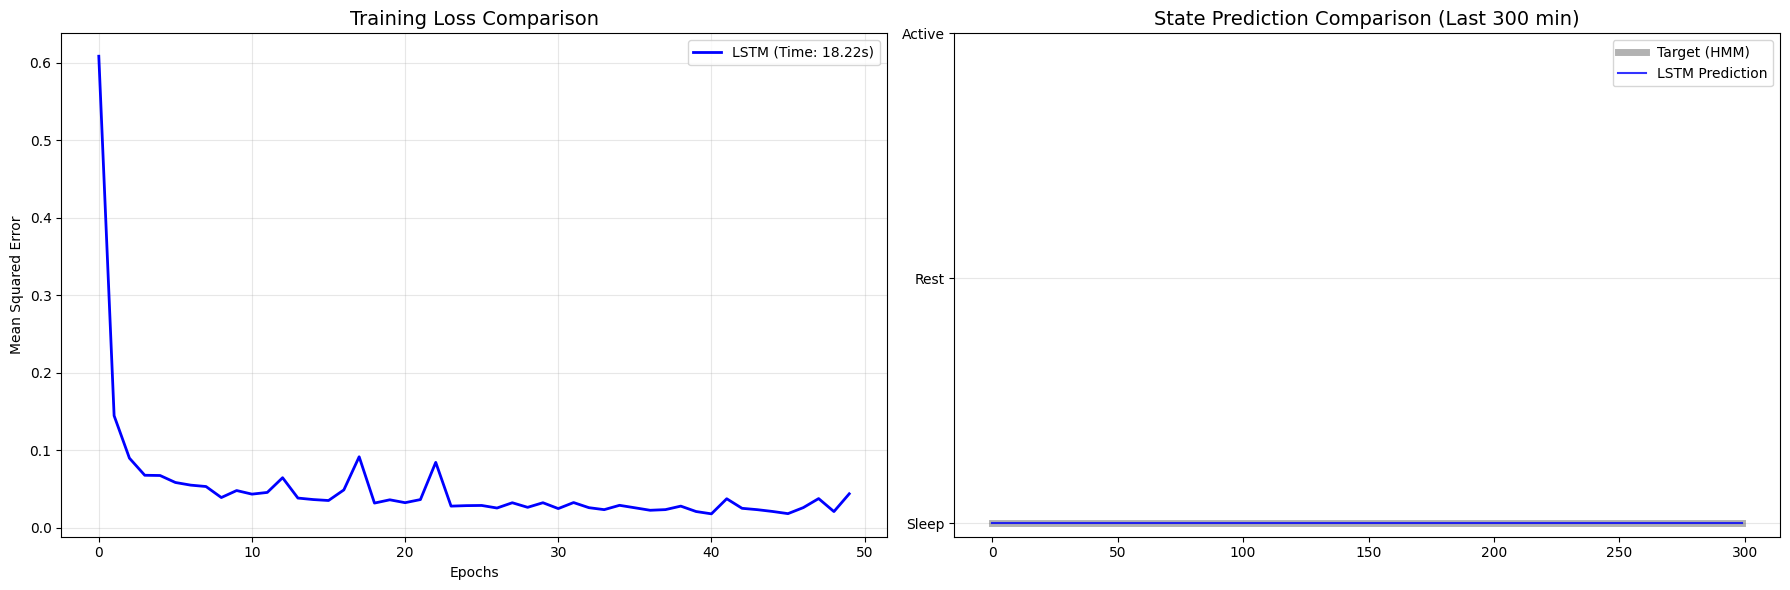

Total Train Time -> LSTM: 18.22s


In [8]:
import time

# ---------------------------------------------------------
# 1. 모델 학습 함수 (비교를 위해 모듈화)
# ---------------------------------------------------------
def train_model(model, loader, criterion, optimizer, epochs=50):
    model.train()
    loss_history = []
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss / len(loader))
    
    end_time = time.time()
    return loss_history, end_time - start_time

# 모델 생성 및 설정
lstm_model = BiorythmLSTM(input_size, 64, num_classes)

criterion = nn.CrossEntropyLoss()
lstm_opt = optim.Adam(lstm_model.parameters(), lr=0.001)

# 학습 실행
print("LSTM 학습 중...")
lstm_loss, lstm_time = train_model(lstm_model, train_loader, criterion, lstm_opt)


# ---------------------------------------------------------
# 2. 시각적 비교 분석
# ---------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# (1) Loss 수렴 속도 비교
ax1.plot(lstm_loss, label=f'LSTM (Time: {lstm_time:.2f}s)', color='blue', linewidth=2)
ax1.set_title("Training Loss Comparison", fontsize=14)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean Squared Error")
ax1.legend()
ax1.grid(True, alpha=0.3)

# (2) 예측 결과 시각화 (마지막 300개 샘플)
lstm_model.eval()
with torch.no_grad():
    lstm_final = lstm_model(X_tensor).argmax(dim=1).numpy()

# 실제 HMM 라벨과 비교
test_range = 300 # 시각화를 위해 마지막 300분만 출력
ax2.plot(y_seq[-test_range:], label='Target (HMM)', color='black', alpha=0.3, linewidth=5)
ax2.plot(lstm_final[-test_range:], label='LSTM Prediction', color='blue', alpha=0.8)
ax2.set_title("State Prediction Comparison (Last 300 min)", fontsize=14)
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['Sleep', 'Rest', 'Active'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total Train Time -> LSTM: {lstm_time:.2f}s")

In [9]:
# 예측 예시
with torch.no_grad():
    lstm_pred = lstm_model(X_tensor).argmax(dim=1)